# Cochella vs Normal Tour Analysis 

Exploring the setlists of 4 artists' Coachella Setlist and shows in the year prior or after the Coachella weekends. 

## Analysis Setup

### Imports and Configurations

In [1]:
# Standard imports to run concert_analytics

import sys
import os

PROJECT_ROOT = os.path.abspath(os.path.join(os.path.dirname(""), "../../"))
sys.path.insert(0, PROJECT_ROOT)

import pandas as pd

from postgres import fetch_table,run_query

import logging

logging.basicConfig(level=logging.INFO)  # DEBUG < INFO < WARNING < ERROR < CRITICAL

pd.set_option("display.max_columns", None)  # Show all columns

project_name = 'Coachella-vs-Normal-Tour'


### Gather Data into CSV and dataframe

In [2]:
# fetch setlist and spotify metadata

query="""
select 
	*
from 
	analytics_project.project_002_coachella_master_setlist_data
"""

df = run_query(query)
df['track_song_name'] = df['track_song_name'].apply(
    lambda x: x if len(x) <= 25 else x[:22] + "..."
)
df.to_csv('coachella_vs_normal_tool_master_setlist_data.csv',index=False)
df.head()

,artist_name_hint,event_set_song_id,event_id,event_date,event_info,event_url,event_tour_id,event_tour,venue_id,venue_name,venue_city,venue_state_code,venue_country_code,venue_latitude,venue_longitude,set_index,set_index_reversed,encore_index,encore_flag,song_index,song_index_reversed,song_position_in_set_index,song_position_in_set_index_reversed,song_name,song_info,song_cover_flag,song_cover_artist_mbid,song_cover_artist_name,song_with_flag,song_with_artist_mbid,song_with_artist_name,song_last_event_set_song_id,song_last_event_id,song_last_event_date,is_coachella,coachella_weekend,days_before_first_coachella_date,days_after_last_coachella_date,coachella_analytics_period,artist_display_name,album_id,album_url,album_uri,album_type,album_name,album_total_tracks,album_release_date,album_image_url,album_popularity,track_id,track_url,track_uri,track_disk_number,track_duration_seconds,track_name,track_number,track_popularity,track_irsc,event_total_songs,event_total_sets,event_total_encore_songs,event_total_non_encore_songs,track_song_name,track_duration_minutes,track_popularity_mid_rank_cdf,track_weighted_popularity_mid_rank_cdf
0,Turnstile,0002b3c2920a7a892b5eb923c2be0cc7,bb2917e,2022-07-17,None,https://www.setlist.fm/setlist/turnstile/2022/...,8b6d54e538f4a76258d7e59705075ac5,The Turnstile Love Connection Tour,9df3c61ef0de246d0d65076fff54c276,Hippodrome de Longchamp,Paris,11,FR,48.853000,2.349000,1,1,0,False,17,2,17,2,HOLIDAY,None,False,None,None,False,None,None,95fb27888140129d65dd33cca16c5267,23b2f813,2022-07-18,False,None,NaN,83.0,After Coachella,Turnstile,2NrYPcMmQBlbBxopc2XlzS,https://api.spotify.com/v1/albums/2NrYPcMmQBlb...,spotify:album:2NrYPcMmQBlbBxopc2XlzS,album,GLOW ON,15.0,2021-08-27,https://i.scdn.co/image/ab67616d0000b273a4499c...,70.0,1dB0NylVkpjdOe8DiekIs7,https://api.spotify.com/v1/tracks/1dB0NylVkpjd...,spotify:track:1dB0NylVkpjdOe8DiekIs7,1.0,172.0,HOLIDAY,5.0,66.0,NLA322100053,18,1,0,18,HOLIDAY,2.866667,0.823029,2.359348
1,BillieEilish,00099633e8cf805879ce7c019f3327a2,bb1ad0a,2022-09-26,None,https://www.setlist.fm/setlist/billie-eilish/2...,f5c70423c1e8640af77041cb8d1217ec,Happier Than Ever: The World Tour,7e38a6c0215ed5a7bfe6ed06ad6dbd0a,Rod Laver Arena,Melbourne,VIC,AU,-37.813997,144.963323,1,4,0,False,5,18,5,7,my strange addiction,None,False,None,None,False,None,None,f13f017985f214560d8519180916fd20,43b19b37,2022-09-29,False,None,NaN,154.0,After Coachella,Billie Eilish,0S0KGZnfBGSIssfF54WSJh,https://api.spotify.com/v1/albums/0S0KGZnfBGSI...,spotify:album:0S0KGZnfBGSIssfF54WSJh,album,"WHEN WE ALL FALL ASLEEP, WHERE DO WE GO?",14.0,2019-03-29,https://i.scdn.co/image/ab67616d0000b27350a314...,88.0,3Tc57t9l2O8FwQZtQOvPXK,https://api.spotify.com/v1/tracks/3Tc57t9l2O8F...,spotify:track:3Tc57t9l2O8FwQZtQOvPXK,1.0,179.0,my strange addiction,9.0,78.0,USUM71900769,22,4,0,22,my strange addiction,2.983333,0.580420,1.731585
2,Turnstile,000a22e3fdc7b20060c6406825cc5456,5bbec328,2022-11-03,None,https://www.setlist.fm/setlist/turnstile/2022/...,8b6d54e538f4a76258d7e59705075ac5,The Turnstile Love Connection Tour,ba63d9d2a43b3084aa8e4a412c794be1,Hollywood Palladium,Los Angeles,CA,US,34.052000,-118.244000,1,1,0,False,11,8,11,8,FLY AGAIN,None,False,None,None,False,None,None,5e3fb90c469b1808dd14efac5b8712cf,4bbecf82,2022-11-04,False,None,NaN,192.0,After Coachella,Turnstile,2NrYPcMmQBlbBxopc2XlzS,https://api.spotify.com/v1/albums/2NrYPcMmQBlb...,spotify:album:2NrYPcMmQBlbBxopc2XlzS,album,GLOW ON,15.0,2021-08-27,https://i.scdn.co/image/ab67616d0000b273a4499c...,70.0,53mkoU4zonxWTbgcNOYy1b,https://api.spotify.com/v1/tracks/53mkoU4zonxW...,spotify:track:53mkoU4zonxWTbgcNOYy1b,1.0,151.0,FLY AGAIN,8.0,59.0,NLA322100056,18,1,0,18,FLY AGAIN,2.516667,0.693817,1.746106
3,BillieEilish,000cd01c9ddfa1de5f8f2cc34c2039c1,63b42233,2022-06-12,None,https://www.setlist.fm/setlist/billie-eilish/2...,f5c70423c1e8640af77041cb8d1217ec,Happier Than Ever: The World Tour,0d8a3b979d5d2dd3ebe3f23fb41be142,The O2 Arena,London,ENG,GB,51.508415,-0.125533,1,4,

### Plotting Imports

In [73]:
from plotnine import ggplot, aes, geom_col, labs, theme, element_text, element_rect, scale_x_datetime, element_blank,element_line

#Colors
gaffer_colors = {
    "lightAmpOrange": "#FB9E50"
    , "floodPink": "#F986BA"
    , "setlistBlue": "#3C7DC4"
    , "spotRed": "#D64848"
    , "ampOrange": "#F25C05"
    , "lightBlue":"#A7ECF5"
    , "encorePurple": "#5D4E8C"
    , "stageGreen": "#33C27D"
    , "clockYellow": "#F6D357"
    , "spotlightCream": "#FAF3E0"
    , "gafferGrey": "#777777"
    , "backstageBlack":"#1C1C1C"
}

def default_labels(additional_sources=[]):
    sources = 'setflist.fm'
    if len(additional_sources) > 0:
        for source in additional_sources:
            sources += f', {source}'

    default_labels = labs(
            caption = f"Source: {sources} sourced via Concert Analytics"
        )

    return default_labels

def gaffer_theme(fig_width=9,fig_height=16,panel_grid='x'):
    #panel_grid can be x, y, or both
    #Basic Fonts
    base_family_axis="Courier New"
    base_family_title="Helvetica"

    # Define the grid line element once
    grid_line = element_line(
        color=gaffer_colors["gafferGrey"],
        linetype="dashed",
        size=0.5
    )

    # Determine which grid lines to show
    panel_grid_y = grid_line if panel_grid in ("y", "both") else element_blank()
    panel_grid_x = grid_line if panel_grid in ("x", "both") else element_blank()

    gaffer_theme = theme(
        # aspect_ratio = 9 / 16
        # , 
        figure_size=(fig_width,fig_height)
        
        # Backgrounds
        , plot_background=element_rect(fill=gaffer_colors["spotlightCream"], color=None)
        , panel_background=element_rect(fill=gaffer_colors["spotlightCream"], color=None)
        , panel_border=element_blank()

        #Margins
        , plot_margin_top= .03
        , plot_margin_bottom=.025
        , plot_margin_right= 0.03
        , plot_margin_left=0.03

        # Titles & subtitles
        , plot_title=element_blank()
        , plot_subtitle=element_blank()
        
        , plot_caption=element_text(
            family=base_family_axis
            , size=12
            , color=gaffer_colors["gafferGrey"]
            , ha='right'
            , margin={'t': 30}  # spacing above caption
        )

        # Axis
        , axis_title=element_text(
            family=base_family_axis
            , size=12
            , color=gaffer_colors["gafferGrey"]
            , weight='ultralight'
            # ,margin={'t': 5, 'r': 5}  # tweak based on axis
        )
        
        , axis_text=element_text(
            family=base_family_axis
            , size=12
            , color=gaffer_colors["gafferGrey"]
            # ,margin={'l':5, 't':20}
        )

        , axis_title_y=element_blank()
        
        , axis_ticks=element_line(
            color=gaffer_colors["spotlightCream"]
        )
        , axis_ticks_minor=element_blank()

        , panel_grid_major_y = panel_grid_y
        , panel_grid_major_x = panel_grid_x
        , panel_grid_minor=element_blank()

        # Legend
        , legend_title=element_blank()
        , legend_background=element_blank()
        , legend_key=element_blank()
        , legend_key_width=10
        , legend_position="top"
        , legend_margin=1
        , legend_direction="vertical"
        # ,legend_margin=margins(t=5, b=5)
        # ,legend_box_margin=margins(t=10)
    )

    return gaffer_theme

def gaffer_facets():
    """
    Facet styling preset for On The Setlist · Gaffer.
    """
    return theme(
        # facet title
        strip_text=element_text(
            size=12
            , family="Courier New"
            , color=gaffer_colors["backstageBlack"]
        )
        , strip_background=element_blank()
        , axis_title_x=element_blank() 
    )


import numpy as np
from plotnine import stat_summary

def add_mean_line():
    mean_line = stat_summary(
        geom="crossbar"
        , fun_y=np.mean
        , fun_ymin=np.mean
        , fun_ymax=np.mean
        , width=0.45
        , size=0.6
        , color=gaffer_colors['stageGreen']
    )
    return mean_line


def export_chart(plot,chart_number="000",viz_name="unnamed",project_name="no-project",width=16,height=9):
    filename=f"viz/{project_name}_{chart_number}_{viz_name}.svg"

    plot.save(
        filename=filename,
        format="svg",
        width=width,      # inches
        height=height,     # adjust to your chart’s shape
        dpi=300        # high-quality output
    )

## Analysis

### What it's Store for Us

#### Shows over time

In [ ]:
chart_number = "001"
viz_name = "Overview-of-Shows"

overview_df = (
    df
    .groupby(["artist_display_name", "coachella_analytics_period"])
    .agg(num_shows=("event_id", "nunique"))
    .reset_index()
)

coachella_analytics_period_order = ["After Coachella","Coachella", "Before Coachella"]

overview_df["coachella_analytics_period"] = pd.Categorical(
    overview_df["coachella_analytics_period"],
    categories=coachella_analytics_period_order,
    ordered=True
)

from IPython.display import display
from plotnine import *
from mizani.breaks import date_breaks
from mizani.formatters import date_format


plot = (
    ggplot(overview_df, aes(x='artist_display_name', y='num_shows', fill='coachella_analytics_period'))
    + geom_col(position="stack")
    + coord_flip()
    + labs(
        x="Artist",
        y="Number of Shows"
    )
    + scale_fill_manual(values={
        "Before Coachella": gaffer_colors["lightBlue"],
        "Coachella": gaffer_colors["stageGreen"],
        "After Coachella": gaffer_colors["lightAmpOrange"]
    })
    + gaffer_theme(fig_width=16, fig_height=9, panel_grid="y")
    + default_labels

)

plot
# export_chart(plot,chart_number=chart_number,viz_name=viz_name,project_name=project_name)

# overview_df.head(100)



#### Song Frequency vs. Coachella Feature

In [ ]:
chart_number = "002"
viz_name = "Overview-Of-Songs"


# Count how often each song was played
artist_song_counts_df = (
    df.groupby(["artist_name_hint","coachella_analytics_period","track_song_name"])
    .agg(
        frequency=("song_name", "count"),
    )
    .reset_index()
    .sort_values("artist_name_hint")
    .sort_values("frequency", ascending=False)
    .reset_index(drop=True)
)

coachella_analytics_period_order = ["After Coachella","Coachella", "Before Coachella"]

artist_song_counts_df["coachella_analytics_period"] = pd.Categorical(
    artist_song_counts_df["coachella_analytics_period"],
    categories=coachella_analytics_period_order,
    ordered=True
)

artists = [
        'JapaneseBreakfast'
        , 'BillieEilish'
        , 'Turnstile'
        ]

from IPython.display import display
from plotnine import ggplot, aes, geom_bar, coord_flip, labs, scale_fill_manual 
from pandas.api.types import CategoricalDtype

for artist in artists:
    # Create the base plot

    artist_df = (
        artist_song_counts_df[artist_song_counts_df["artist_name_hint"] == artist]
        .reset_index(drop=True)
    )

    # Set up ordering of track_song_name by overall frequency per artist
    artist_df["track_song_name"] = pd.Categorical(
        artist_df["track_song_name"],
        categories=artist_df.groupby("track_song_name")["frequency"]
            .sum()
            .sort_values(ascending=True)
            .index,
        ordered=True
    )
    
    plot = (
        ggplot(artist_df, aes(x='track_song_name', y='frequency', fill='coachella_analytics_period'))
        + geom_col(position="stack")
        + coord_flip()
        + labs(
            x="Song Name",
            y="Song Frequency"
        )
        + scale_fill_manual(values={
            "Before Coachella": gaffer_colors["lightBlue"],
            "Coachella": gaffer_colors["stageGreen"],
            "After Coachella": gaffer_colors["lightAmpOrange"]
        })
        + gaffer_theme(fig_width=9,fig_height=12)
        + default_labels
    )
    
    # print(artist)
    # display(plot)
    viz_name_final = f"{artist}-{viz_name}"
    export_chart(plot,chart_number=chart_number,viz_name=viz_name_final,project_name=project_name,width=9,height=12)
    


### Popularity Research

#### Frequency by Popularity

In [ ]:
chart_number = "003"

song_stats = (
    df
    .groupby(['artist_name_hint','track_song_name','album_name'], as_index=False)
    .agg(
        times_played=('event_id', 'nunique')
        , avg_popularity=('track_popularity', 'mean')
        , avg_duration=('track_duration_seconds', lambda x: x.mean() / 60)
        , coachella_flag=('is_coachella','any')
    )
)

def is_hero(row, artist_avg_popularity, artist_times_played, artist_std_popularity, artist_std_times_played):
    top_popularity = artist_avg_popularity + (artist_std_popularity)
    top_mid_popularity = artist_avg_popularity + (artist_std_popularity * .25)
    bottom_mid_popularity = artist_avg_popularity - (artist_std_popularity * .25)
    bottom_popularity = artist_avg_popularity - (artist_std_popularity)

    top_times_played = artist_times_played + (artist_std_times_played)
    top_mid_times_played = artist_times_played + (artist_std_times_played*.25)
    bottom_mid_times_played = artist_times_played - (artist_std_times_played*.25)
    bottom_times_played = artist_times_played - (artist_std_times_played)

    return (
        (row['avg_popularity'] > top_popularity and row['times_played'] > top_times_played) # crowd favorite
        or (row['avg_popularity'] < bottom_popularity and row['times_played'] > top_times_played)  # band favorite
        or (row['avg_popularity'] > top_popularity and row['times_played'] < bottom_times_played)  # rare banger
        or (row['avg_popularity'] < bottom_popularity and row['times_played'] < bottom_times_played) # ultra obscurity
        or (
        (row['avg_popularity'] > bottom_mid_popularity and row['avg_popularity'] < top_mid_popularity)
        and (row['times_played'] > bottom_mid_times_played and row['times_played'] < top_mid_times_played)
        )  # the mid point
    )


artists = [
        'JapaneseBreakfast'
        , 'BillieEilish'
        , 'Turnstile'
        ]

from plotnine import *


for artist in artists:
    # Create the base plot

    artist_df = (
        song_stats[song_stats["artist_name_hint"] == artist]
        .reset_index(drop=True)
    )

    avg_times_played = artist_df['times_played'].mean()
    std_times_played = artist_df['times_played'].std()
    avg_popularity = artist_df['avg_popularity'].mean()
    std_popularity = artist_df['avg_popularity'].std()

    print(f"Times Played:{avg_times_played}, Standard Dev:{std_times_played}, Average Popularity:{avg_popularity}, Standard Dev:{std_popularity}")
    artist_df['label'] = artist_df.apply(lambda row: row['track_song_name'] if is_hero(row,avg_popularity,avg_times_played,std_popularity,std_times_played) else '', axis=1)

    scatter_chart = (
        ggplot(artist_df, aes(x='avg_popularity', y='times_played'))
        + geom_point(aes(color='coachella_flag'), size=3, alpha=0.8,show_legend=False)
        + geom_text(aes(label='label'), nudge_y=0.6, size=8, color="#1c1c1c", alpha=0.8)
        + labs(
            x='Track Popularity'
            ,y='Times Played'
        )
        + scale_color_manual(values={
            True:gaffer_colors['stageGreen']
            ,False:gaffer_colors['gafferGrey']
        }
        )
        + geom_vline(
            xintercept=avg_popularity,
            linetype="dashed",
            color="#F25C05",
            size=1,
            alpha=0.8
        )
        + annotate(
            'text',
            x=27.75,
            y=29,
            label='Average Popularity',
            size=10,
            color="#F25C05",
            # family=base_family_axis
        )
        + geom_hline(
            yintercept=avg_times_played,
            linetype="dashed",
            color="#F25C05",
            size=1,
            alpha=0.8
        )
        + annotate(
            'text',
            x=17,
            y=song_stats['times_played'].mean() + 1,
            label='Average Times Played',
            size=10,
            color="#F25C05",
            # family=base_family_axis
        )
        + gaffer_theme(fig_width=16,fig_height=9,panel_grid='both')
        + default_labels
    )

    print(artist)
    display(scatter_chart)

song_stats.to_csv("003-Coachella-Times_Played_vs_Popularity.csv", index=False)

# # scatter_chart
# scatter_chart.save(
#     filename="viz/0002-mewithoutYou-Times_Played_vs_Popularity.svg",
#     format="svg",
#     width=16,      # inches
#     height=9,     # adjust to your chart’s shape
#     dpi=300        # high-quality output
# )

#### Weighted Net Popularity Score Comparisons

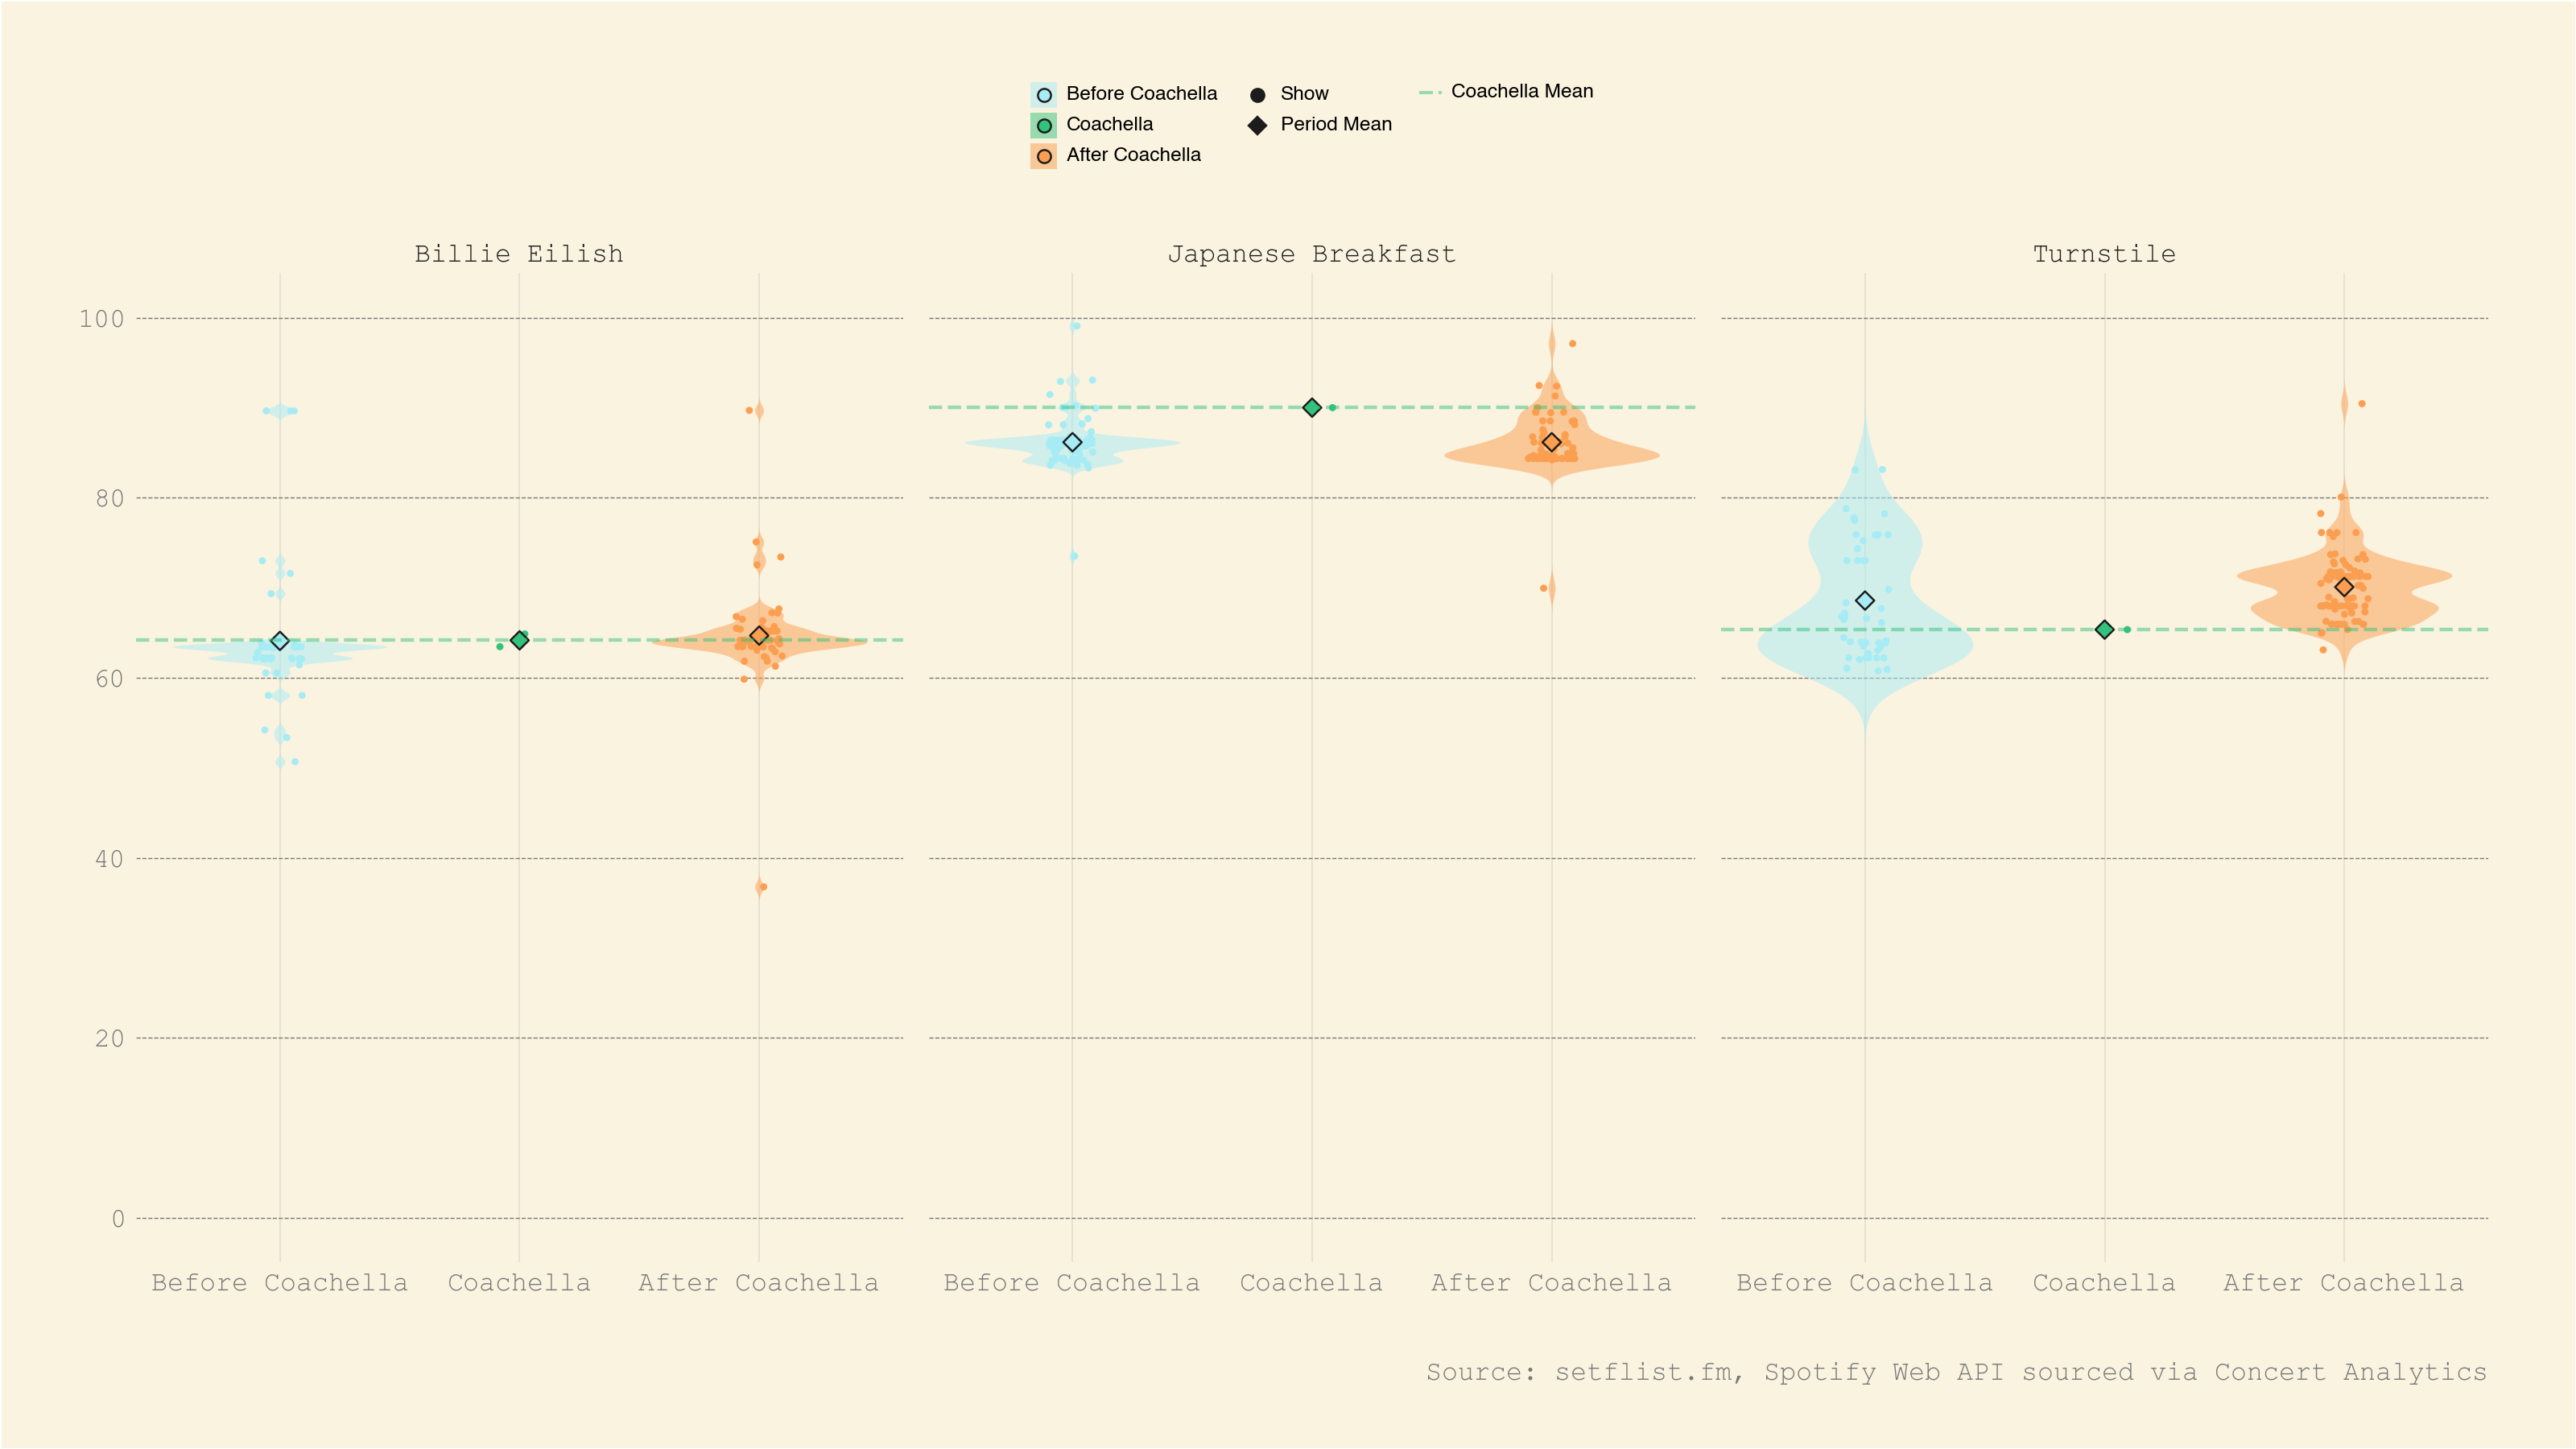

In [75]:
chart_number = "003"
viz_name = "Weighted-Net-Popularity-Score"

set_popularity_scores_event_level = (
    df.groupby(['artist_display_name','event_id','coachella_analytics_period'], as_index=False)
    .agg(
        songs_played=('event_set_song_id', 'nunique')
        , sum_track_weighted_popularity_mid_rank_cdf=('track_weighted_popularity_mid_rank_cdf', 'sum')
        , sum_track_duration=('track_duration_minutes', 'sum')
    )
)

set_popularity_scores_event_level['weighted_show_popularity_score'] = (
    set_popularity_scores_event_level['sum_track_weighted_popularity_mid_rank_cdf'] 
    / set_popularity_scores_event_level['sum_track_duration'] 
)

set_popularity_scores_period_level = (
        set_popularity_scores_event_level[set_popularity_scores_event_level['songs_played'] > 5]
        .groupby(['artist_display_name','coachella_analytics_period'], as_index=False)
    .agg(
        total_shows =('event_id', 'nunique')
        , max_weighted_show_popularity_score=('weighted_show_popularity_score','max')
        , min_weighted_show_popularity_score=('weighted_show_popularity_score','min')
        , avg_weighted_show_popularity_score=('weighted_show_popularity_score','mean')
        , min_songs_played=('songs_played','min')
        , max_songs_played=('songs_played','max')
        , avg_songs_played=('songs_played','mean')
        , min_sum_track_duration=('sum_track_duration','min')
        , max_sum_track_duration=('sum_track_duration','max')
        , avg_sum_track_duration=('sum_track_duration','mean')
    )
)

# Ensure period ordering & tidy labels
period_order = ["Before Coachella", "Coachella", "After Coachella"]
set_popularity_scores_event_level = (
    set_popularity_scores_event_level.assign(
        coachella_analytics_period=pd.Categorical(
            set_popularity_scores_event_level["coachella_analytics_period"],
            categories=period_order,
            ordered=True
        )
    )
)

set_popularity_scores_event_level_violin = (
    set_popularity_scores_event_level[set_popularity_scores_event_level['coachella_analytics_period'] != 'Coachella']
    .reset_index(drop=True)
)



# If your weighted_show_popularity_score is 0–1 and you prefer % for axes, make a helper column
# if set_popularity_scores_event_level["weighted_show_popularity_score"].max() <= 1.0:
set_popularity_scores_event_level = set_popularity_scores_event_level.assign(weighted_show_popularity_score_pct=lambda d: d["weighted_show_popularity_score"] * 100)
set_popularity_scores_event_level_violin = set_popularity_scores_event_level_violin.assign(weighted_show_popularity_score_pct=lambda d: d["weighted_show_popularity_score"] * 100)

coach_means = (
    set_popularity_scores_event_level
      .query('coachella_analytics_period == "Coachella"')
      .groupby('artist_display_name', as_index=False)
      .agg(mean_coachella=(ycol, 'mean'))
)

ycol = "weighted_show_popularity_score_pct"
ylab = "Weighted Popularity (% of max possible)"
# else:
# ycol = "weighted_show_popularity_score"
# ylab = "Weighted Popularity (% of max possible)"

import numpy as np
import pandas as pd
from plotnine import (
    ggplot, aes, geom_violin, geom_point, geom_boxplot, stat_summary,
    scale_y_continuous, scale_x_discrete, facet_wrap, labs, theme, element_text,
    position_jitter, position_dodge, coord_cartesian, scale_fill_manual, geom_hline
    , scale_shape_manual, scale_linetype_manual, guides, guide_legend
)

plot = (
    ggplot(set_popularity_scores_event_level, aes(x="coachella_analytics_period", y=ycol, fill="coachella_analytics_period"))
    # Violin shows the full distribution shape per period
    + geom_violin(
        data=set_popularity_scores_event_level_violin
        , width=0.9
        , trim=False
        , scale="width"
        , alpha=.5
        , color=None
        , show_legend=True
        )
    + geom_point(
        aes(shape='"Show"')
        , position=position_jitter(
            width=0.1
            , height=0
            )
        , size=1.8
        , alpha=1
        , color=gaffer_colors["backstageBlack"]
        , stroke=0
        , show_legend=True
    )
    # Mean marker (a small horizontal dash)
    + stat_summary(
        aes(shape='"Period Mean"')
        , geom="point"
        , fun_y=np.mean
        , color=gaffer_colors["backstageBlack"]
        , size=2.8
        , show_legend=True
    )
    + geom_hline(
        data=coach_means
        , mapping=aes(
            yintercept='mean_coachella'
            , linetype='"Coachella Mean"'
            )
        , color=gaffer_colors["stageGreen"]
        , size=0.9
        , alpha=0.5
        , show_legend=True
    )
    + scale_fill_manual(values={
        "Before Coachella": gaffer_colors["lightBlue"]
        , "Coachella": gaffer_colors["stageGreen"]
        , "After Coachella": gaffer_colors["lightAmpOrange"]
        })
    # NEW: shapes for the “element” legend
    + scale_shape_manual(
        name="Elements",            # legend title for shapes
        values={"Show": "o", "Period Mean": "D"}  # pick your glyphs: 'o'=circle, 'D'=diamond, etc.
    )

    # NEW: linetype legend for the hline
    + scale_linetype_manual(
        name="Reference",
        values={"Coachella Mean": "dashed"}
    )

    # Put legends in a sensible order
    + guides(
        fill=guide_legend(order=1, title="Period"),
        shape=guide_legend(order=2),
        linetype=guide_legend(order=3)
    )
    # Facet by artist so periods are comparable within each artist
    + facet_wrap("~artist_display_name", nrow=1)
    # Keep axis nice for % scale
    + scale_y_continuous(limits=(0, 100), breaks=range(0, 101, 20))
    + scale_x_discrete(drop=False)
    # Minimal theming
    + gaffer_theme(fig_width=16,fig_height=9,panel_grid='y')
    + gaffer_facets()
    + theme(
        panel_grid_major_x=element_line(
            color=gaffer_colors["gafferGrey"]
            , linetype="solid"
            , size=0.1
        )
    )
    + default_labels(['Spotify Web API'])
)

plot
# export_chart(plot,chart_number=chart_number,viz_name=viz_name,project_name=project_name)

In [ ]:


set_popularity_scores_event_level_violin.head(200)